In [1]:
import random
import networkx as nx
import numpy as np
import torch
from torch_geometric.utils.convert import from_networkx
import random
import networkx as nx
from collections import Counter, defaultdict
from torch_geometric.loader import DataLoader
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import src.utils.utils as ut
import os
import pickle
import datetime
from multiprocessing import Process, Pool

In [16]:
graphs_dir = '/home/sysbio/DBG-GNN/data/camda2020_tiny_max'
graphs = []
for file in os.listdir(graphs_dir):
    if not file.startswith('CAMDA'):
        print(f'skipping {file}')
        continue
    print(f'reading {file}')
    with open(os.path.join(graphs_dir, file), 'rb') as f:
        graph = pickle.load(f)
    graphs.append(graph)

skipping SCL.labeled_graph_max
reading CAMDA20_MetaSUB_CSD16_BCN_017_1_kneaddata_subsampled_20_percent.labeled_graph_max
reading CAMDA20_MetaSUB_CSD16_ILR_022_1_kneaddata_subsampled_20_percent.labeled_graph_max
reading CAMDA20_MetaSUB_CSD17_HKG_010_1_kneaddata_subsampled_20_percent.labeled_graph_max
skipping HKG.labeled_graph_max
reading CAMDA20_MetaSUB_CSD16_BCN_012_1_kneaddata_subsampled_20_percent.labeled_graph_max
reading CAMDA20_MetaSUB_CSD16_FAI_020_1_kneaddata_subsampled_20_percent.labeled_graph_max
reading CAMDA20_MetaSUB_CSD16_SCL_009_1_kneaddata_subsampled_20_percent.labeled_graph_max
reading CAMDA20_MetaSUB_CSD16_DOH_044_1_kneaddata_subsampled_20_percent.labeled_graph_max
reading CAMDA20_MetaSUB_CSD16_FAI_009_1_kneaddata_subsampled_20_percent.labeled_graph_max
reading CAMDA20_MetaSUB_CSD16_BCN_026_1_kneaddata_subsampled_20_percent.labeled_graph_max
reading CAMDA20_MetaSUB_CSD16_FAI_024_1_kneaddata_subsampled_20_percent.labeled_graph_max
reading CAMDA20_MetaSUB_CSD16_DOH_013_

In [17]:
graphs[0]

Data(x=[512, 25], edge_index=[2, 2161], weight=[2161], y=[1])

In [18]:
graphs[1]

Data(x=[561, 25], edge_index=[2, 2343], weight=[2343], y=[1])

In [19]:
graphs_n = len(graphs)

In [20]:
random.shuffle(graphs)
split_value = 0.8
train_dataset = graphs[:int(graphs_n * split_value)]
val_dataset = graphs[int(graphs_n * split_value):]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [21]:
val_loader

In [22]:
len(val_loader)

3

In [31]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, edge_weight, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_weight)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_weight)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [32]:
kmer_len = 4
subkmer_len = 2
num_features = 5**subkmer_len
num_classes = 6

In [33]:
def train():
    model.train()
    total_loss = 0
    correct = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.weight, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    return total_loss / len(train_loader), correct / len(train_dataset)

# Validation function
def validate(loader):
    model.eval()
    correct = 0
    for data in loader:
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.weight, data.batch)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)

# Initialize the model, optimizer, and loss function
model = GCN(num_features=num_features, hidden_channels=32, num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
train_loss_for_plot = []
train_acc_for_plot = []
val_acc_for_plot = []
num_epochs = 3000
for epoch in range(num_epochs):
    train_loss, train_acc = train()
    val_acc = validate(val_loader)
    train_loss_for_plot.append(train_loss)
    train_acc_for_plot.append(train_acc)
    val_acc_for_plot.append(val_acc)
    if epoch % 200 == 0:
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')


Epoch 1, Train Loss: 1.7988, Train Acc: 0.3333, Val Acc: 0.3333
Epoch 201, Train Loss: 0.9024, Train Acc: 0.6667, Val Acc: 0.6667
Epoch 401, Train Loss: 0.4798, Train Acc: 0.7778, Val Acc: 0.6667
Epoch 601, Train Loss: 0.3656, Train Acc: 0.8889, Val Acc: 0.6667
Epoch 801, Train Loss: 0.0921, Train Acc: 1.0000, Val Acc: 0.6667
Epoch 1001, Train Loss: 0.2507, Train Acc: 0.8889, Val Acc: 0.6667
Epoch 1201, Train Loss: 0.1015, Train Acc: 0.8889, Val Acc: 0.6667
Epoch 1401, Train Loss: 0.1052, Train Acc: 1.0000, Val Acc: 0.6667
Epoch 1601, Train Loss: 0.0098, Train Acc: 1.0000, Val Acc: 0.6667
Epoch 1801, Train Loss: 0.0121, Train Acc: 1.0000, Val Acc: 0.6667
Epoch 2001, Train Loss: 0.0009, Train Acc: 1.0000, Val Acc: 0.6667
Epoch 2201, Train Loss: 0.0073, Train Acc: 1.0000, Val Acc: 0.6667
Epoch 2401, Train Loss: 0.0101, Train Acc: 1.0000, Val Acc: 0.6667
Epoch 2601, Train Loss: 0.0196, Train Acc: 1.0000, Val Acc: 0.6667
Epoch 2801, Train Loss: 0.1605, Train Acc: 0.8889, Val Acc: 0.6667


In [34]:
import matplotlib.pyplot as plt
import matplotlib as mpl

Text(0.5, 1.0, 'train loss')

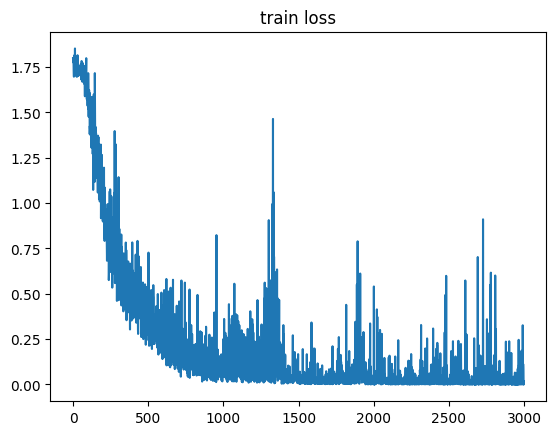

In [35]:
plt.plot(train_loss_for_plot)
plt.title('train loss')

Text(0.5, 1.0, 'train acc')

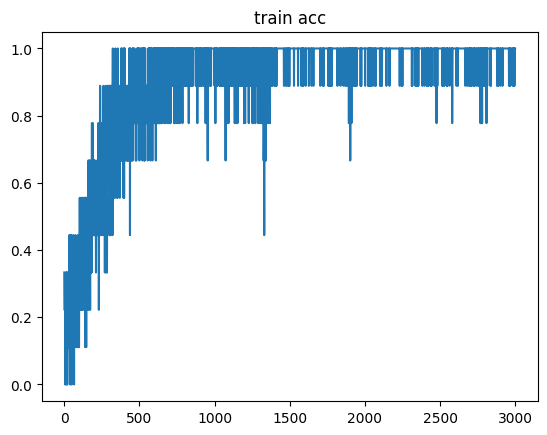

In [36]:
plt.plot(train_acc_for_plot)
plt.title('train acc')

Text(0.5, 1.0, 'val acc')

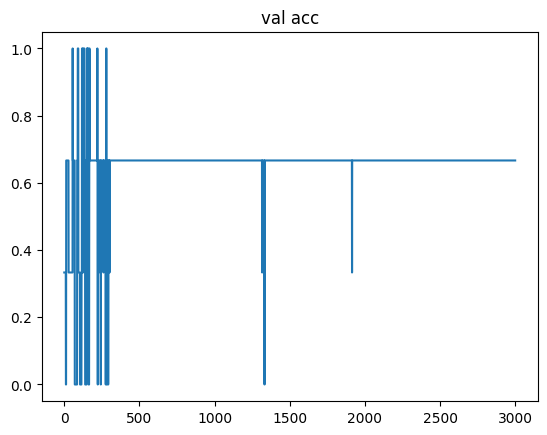

In [37]:
plt.plot(val_acc_for_plot)
plt.title('val acc')

In [38]:
models_outdir = '/home/sysbio/DBG-GNN/trained_models'
model_outfile = os.path.join(models_outdir, 'camda2020_tiny_max_gcn.model')
with open(model_outfile, 'wb') as f:
    pickle.dump(model, f)